In [2]:
import matplotlib as mpl
import numpy as np
import pandas as pd
import matplotlib.colors as mcolors


the_textwidth = 0.5*487.8225 #234.877
golden_ratio = (np.sqrt(5.0) - 1.0) / 2.0


def figsize(width, ratio=golden_ratio, height=None):
    fig_width_pt = the_textwidth  # Get this from LaTeX using \the\textwidth
    inches_per_pt = 1.0 / 72.27  # Convert pt to inch
    fig_width = fig_width_pt * inches_per_pt * width  # width in inches
    fig_height = fig_width * ratio  # height in inches
    return [fig_width, height or fig_height]


pgf_with_latex = {  # setup matplotlib to use latex for output
    "pgf.texsystem": "pdflatex",  # change this if using xetex or lautex
    "text.usetex": True,  # use LaTeX to write all text
    "font.family": "serif",
    "font.serif": [],  # blank entries should cause plots to inherit fonts from the document
    "font.sans-serif": [],
    "font.monospace": [],
    "font.size": 6,
    "figure.figsize": figsize(0.9),  # default fig size of 0.9 textwidth
    "pgf.preamble": '\n'.join([
        r"\usepackage[utf8x]{inputenc}",  # use utf8 fonts becasue your computer can handle it :)
        r"\usepackage[T1]{fontenc}",  # plots will be generated using this preamble
    ])
}

mpl.rcParams.update(pgf_with_latex)


import matplotlib.pyplot as plt

plt.style.use(['tableau-colorblind10'])

def savefig(fig, filename):
    # fig.savefig(f'figs/{filename}.pgf', bbox_inches='tight')
    fig.savefig(f'{filename}.pdf', bbox_inches='tight')

tcol = mcolors.TABLEAU_COLORS
colours = {'MLE': tcol['tab:gray'], 'PHE': tcol['tab:olive'], 'EVILL': tcol['tab:purple'], 'TSL': tcol['tab:cyan']}

def sem(v, axis=0):
    stds = np.std(v, axis=axis) 
    l = v.shape[axis]
    return stds / np.sqrt(l)

def conf_intervals(v):
    mean = np.mean(v, axis=0)
    err = sem(v, axis=0)
    return (mean - err, mean, mean + err)

def disable_spines(axs):
    for ax in axs:
        ax.spines[['right', 'top']].set_visible(False)

In [3]:
r_est_rayleigh = np.load("results/rayleigh_estimation.npz", allow_pickle=True)['arr_0'].item()
r_rayleigh = np.load("results/rayleigh_bandit.npz", allow_pickle=True)['arr_0'].item()
r_logistic_low_var = np.load("results/logistic_low_var.npz", allow_pickle=True)['arr_0'].item()
r_logistic_high_var = np.load("results/logistic_high_var.npz", allow_pickle=True)['arr_0'].item()

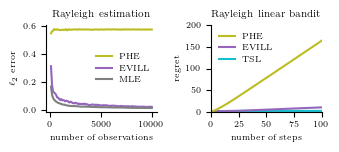

In [4]:
def make_rayleigh_plots():
    fig, (ax_est, ax_bandit) = plt.subplots(1,2, figsize=figsize(width=1.0, height=1.5))
    
    disable_spines((ax_est, ax_bandit))
    
    keys = ['PHE', 'EVILL', 'MLE']
    x_est = np.array(r_est_rayleigh['x_values'])
    
    for key in keys:
        v = np.array(r_est_rayleigh[key])
        ax_est.plot(x_est, np.mean(v, axis=0), label=key, c=colours[key])
    
    ax_est.legend(frameon=False)
    ax_est.set_title('Rayleigh estimation')
    ax_est.set_ylabel('$\ell_2$ error')
    ax_est.set_xlabel('number of observations')
    
    bandit_keys = ['TSL', 'EVILL', 'PHE' ]
    
    for key in bandit_keys:
        v = np.array(r_rayleigh[key])
        lb, mean, ub = conf_intervals(v)
        ax_bandit.plot(mean, label=key, c=colours[key])
    ax_bandit.set_xlim(0,100)
    ax_bandit.set_ylim(0, 200)
    h, l = ax_bandit.get_legend_handles_labels()
    ax_bandit.legend(h[::-1], l[::-1], loc='upper left', frameon=False)
    ax_bandit.set_title('Rayleigh linear bandit')
    ax_bandit.set_ylabel('regret')
    ax_bandit.set_xlabel('number of steps')
    
    plt.tight_layout()
    savefig(fig, 'rayleigh')

make_rayleigh_plots()

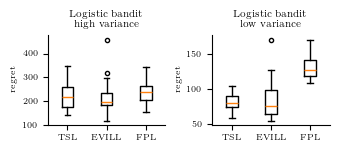

In [5]:
def make_boxplots():
    fig, axs = plt.subplots(1,2, figsize=figsize(width=1.0, height=1.5), sharey=False)
    disable_spines(axs)
    titles = ['Logistic bandit\nhigh variance', 'Logistic bandit\nlow variance']
    for ax, title in zip(axs, titles):
        ax.set_title(title)
    
    keys = ['TSL', 'PHE', 'FPL']
    names = ['TSL', 'EVILL', 'FPL']
    
    for ax, data in zip(axs, (r_logistic_high_var, r_logistic_low_var)):
        vals = [np.array(data[key])[:, -1] for key in keys]
        ax.boxplot(vals, showfliers=True, whis=1.5, flierprops={'marker': 'o', 'markersize': 3})
        ax.set_xticks([1,2,3], [name for name in names])
        ax.set_ylabel('regret')
    fig.tight_layout()
    savefig(fig, 'logistic')

make_boxplots()